In [75]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [76]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACE_API_KEY"]=os.environ["HUGGINGFACE_API_KEY"]
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [77]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from pydantic import BaseModel,Field
from langgraph.graph.message import add_messages
from typing import Annotated
from typing import TypedDict
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from IPython.display import display,Image
from langgraph.graph import StateGraph,START,END


In [78]:
llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash")

In [79]:
embedding=GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [80]:
from langchain_community.document_loaders import TextLoader
loader=TextLoader('sample.txt')
docs=loader.load()
docs

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [81]:
document=RecursiveCharacterTextSplitter(chunk_size=1500,chunk_overlap=50).split_documents(docs)
document

[Document(metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Learning\n\nToday Deep learning AI has become

In [82]:
vectordb=FAISS.from_documents(document,embedding)

In [83]:
db=vectordb.as_retriever()

In [84]:
ret_doc=db.invoke("what is deep learning")

In [85]:
ret_doc

[Document(id='7441b621-3eb9-41d5-a228-74a2cc583dc3', metadata={'source': 'sample.txt'}, page_content='The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.\n\nIn a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.\n\nDeep Learning - Geeksforgeeks\nScope of Deep Le

In [86]:
for doc in ret_doc:
    print(doc.page_content)

The definition of Deep learning is that it is the branch of machine learning that is based on artificial neural network architecture. An artificial neural network or ANN uses layers of interconnected nodes called neurons that work together to process and learn from the input data.

In a fully connected Deep neural network, there is an input layer and one or more hidden layers connected one after the other. Each neuron receives input from the previous layer neurons or the input layer. The output of one neuron becomes the input to other neurons in the next layer of the network, and this process continues until the final layer produces the output of the network. The layers of the neural network transform the input data through a series of nonlinear transformations, allowing the network to learn complex representations of the input data.

Deep Learning - Geeksforgeeks
Scope of Deep Learning

Today Deep learning AI has become one of the most popular and visible areas of machine learning, du

In [87]:
prompt=ChatPromptTemplate.from_template(
    """
        Answer the following question based on the give context
        {context}

        question:{question}  
   """
)

In [88]:
chain=prompt|llm|StrOutputParser()

In [89]:
response=chain.invoke({"context":document,"question":"disadvanatge of deep learning"})

In [90]:
response

'Based on the provided text, the disadvantages of deep learning are:\n\n* **High computational requirements:** Deep learning models need significant computational resources and large amounts of data for training and optimization.\n* **Requires large amounts of labeled data:**  Training often requires extensive labeled data, which can be costly and time-consuming to obtain.\n* **Interpretability:** Deep learning models are complex and can be difficult to interpret, making it hard to understand their decision-making processes.\n* **Overfitting:** Models can overfit to training data, leading to poor performance on new, unseen data.\n* **Black-box nature:**  The inner workings are often opaque, hindering understanding of how they produce predictions.'

In [91]:
class Agenstate(TypedDict):
    question:str
    generation:str
    websearch:str
    documents:list[str]

In [92]:
class Grader(BaseModel):
    """Check the document relevance give binary score 'yes' or 'no' """
    binary_score:str=Field(description="the relevance of binary score 'yes' or 'no' ")

In [93]:
structured_llm=llm.with_structured_output(Grader)

system1="""
    As you are grader assissting relevance export check strictly if the document contain any
    keyword or semantic information related to the question if the question contain any relavance
    you strictly give binary score 'yes' otherwise you only give 'no'
"""

prompt1=ChatPromptTemplate.from_messages([
    ("system",system1),
    ("human","Here is the question: {question} /n/n and here is the document {document}")
])


doc_query_checker=prompt1|structured_llm

In [94]:
question="who built taj mahal"
doc_query_checker.invoke({'question':question,"document":ret_doc})

Grader(binary_score='no')

In [95]:
system2="""
     As you are a query rewritter your task is to reformulate the given question into the better
     version for the web search
"""

prompt2=ChatPromptTemplate.from_messages([
    ("system",system2),
    ("human","Here is the question : {question}")
])

question_rewritter=prompt2|llm

In [96]:
question_rewritter.invoke({"question":question})

AIMessage(content='Who commissioned the construction of the Taj Mahal?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d6d285f4-f824-4604-919c-838b31aae271-0', usage_metadata={'input_tokens': 39, 'output_tokens': 10, 'total_tokens': 49, 'input_token_details': {'cache_read': 0}})

In [97]:
prompt3=ChatPromptTemplate.from_template(
    """
        Answer the following question based on the given context:
        <context>
        {context}
        <context>

        question:{question}
    """
)

gen_answer=prompt3|llm

In [98]:
def retriever(state:Agenstate):
    print("== > RETRIEVING THE DOCUMENT <==")
    question=state["question"]

    documents=db.invoke(question)
    return {"question":question,"documents":documents}

In [99]:
def grading_documents(state:Agenstate):

    print("===> GRADING DOCUMENTS <===")
    question=state["question"]
    documents=state["documents"]

    doclist=[]
    websearch="no"

    for doc in documents:
        grade=doc_query_checker.invoke({"question":question,"document":doc.page_content})
        score=grade.binary_score

        if score=='yes':
            print("ALL DOCUMENTS ARE RELEVANT ")
            doclist.append(doc)

        else:
            print("DOCUMENTS ARE NOT REELAVNT")
            websearch='yes'
            continue
    return {"question":question,"documents":doclist,"websearch":websearch}

In [100]:
def generate(state:Agenstate):
    print("==>GENERATE THE ANSWER <==")
    question=state["question"]
    documents=state["documents"]

    generating=gen_answer.invoke({"question":question,"context":documents})
    return {"question":question,"generation":generating}

In [101]:
search=TavilySearchResults(max_results=3)

In [102]:
search.invoke("who built taj mahal")

[{'url': 'https://smarthistory.org/the-taj-mahal/',
  'content': 'Smarthistory – The Taj Mahal Taj Mahal, Agra, India, 1632–53 (photo: King of Hearts, CC BY-SA 4.0) Shah Jahan built the Taj Mahal in Agra, where he took the throne in 1628. When viewed from the main gateway today, the Taj Mahal appears to deviate from this norm, as it is not centrally placed within the garden, but rather\xa0located at the end of a\xa0complex that is backed by the river, such as was found in other Mughal-era pleasure gardens. View from the Mahtab Bagh, Taj Mahal, Agra, India, 1632–53 (photo: Steve Evans, CC BY-NC 2.0) Relegated to Agra Fort under house arrest for eight years prior to his death in 1666, Shah Jahan could enjoy only a distant view of the Taj Mahal.'},
 {'url': 'https://www.tajmahal.gov.in/taj-story.aspx',
  'content': 'It was built by the fifth Mughal emperor, Shah Jahan in 1631 in memory of his third but the most favourite wife, in fact a soul-mate Mumtaz Mahal, a Muslim'},
 {'url': 'https:

In [103]:
def websearching(state:Agenstate):
    question=state["question"]
    documents=state["documents"]

    result=search.invoke(question)
    web_docs='\n\n'.join(res['content'] for res in result)
    web_result=Document(page_content=web_docs)

    documents.append(web_result)

    return {"question":question,"documents":documents}

In [104]:
def rewritting(state:Agenstate):
    print("==> QUESTION REWRITTING <==")
    question=state["question"]
    documents=state["documents"]
    better_question=question_rewritter.invoke({"question":question})

    print(f" the rewritted question {better_question}")

    return {"question":question,"documents":documents}

In [105]:
def router(state:Agenstate):

    print("===> ENTERING INTO THE ROUTER <===")
    question=state["question"]
    websearch=state["websearch"]

    if websearch=='yes':
        print("==> NEED TO  TRANSFORM THE QUERY <===")
        return "transform"
    else:
        print("===>ALLOW TO GENERATE ANSWER <===")
        return "generate"

In [106]:
graph=StateGraph(Agenstate)

In [107]:
graph.add_node("retrieving_docs",retriever)
graph.add_node("grading_docs",grading_documents)
graph.add_node("generating_answer",generate)
graph.add_node("transforming_query",rewritting)
graph.add_node("web_searching",websearching)
graph.set_entry_point("retrieving_docs")

In [108]:
graph.add_conditional_edges("grading_docs",
                            router,
                            {
                                "transform":"transforming_query",
                                "generate":"generating_answer"
                            })

In [109]:
graph.add_edge("generating_answer",END)
graph.add_edge("retrieving_docs","grading_docs")
graph.add_edge("transforming_query","web_searching")
graph.add_edge("web_searching","grading_docs")

In [110]:
app=graph.compile()

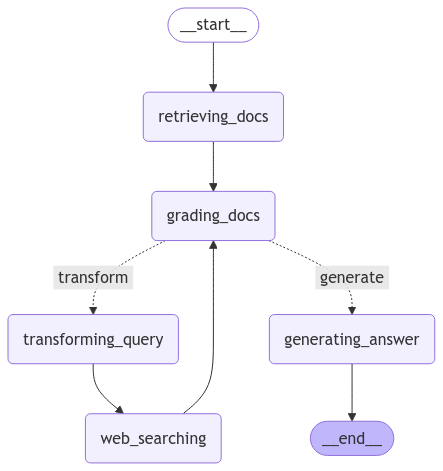

In [111]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [112]:
from pprint import pprint
input={'question':"what is deep learning"}

In [113]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"node {key}")

    pprint("/n.../n")
pprint(value["generation"])

== > RETRIEVING THE DOCUMENT <==
node retrieving_docs
'/n.../n'
===> GRADING DOCUMENTS <===
ALL DOCUMENTS ARE RELEVANT 
ALL DOCUMENTS ARE RELEVANT 
ALL DOCUMENTS ARE RELEVANT 
ALL DOCUMENTS ARE RELEVANT 
===> ENTERING INTO THE ROUTER <===
===>ALLOW TO GENERATE ANSWER <===
node grading_docs
'/n.../n'
==>GENERATE THE ANSWER <==
node generating_answer
'/n.../n'
AIMessage(content="Deep learning is a branch of machine learning based on artificial neural network architecture.  These networks use layers of interconnected nodes (neurons) to process and learn from input data.  In a fully connected deep neural network, information flows through input and one or more hidden layers, with each neuron's output becoming the input for others in the next layer.  This process, involving nonlinear transformations, allows the network to learn complex representations of the input data.  Deep learning's success has made it a popular area of machine learning, used in applications such as computer vision, nat

In [114]:
input1={'question':"how many languages in india"}

In [115]:
for output in app.stream(input1):
    for key,value in output.items():
        print(f"node {key}")

    pprint("/n.../n")
pprint(value["generation"])

== > RETRIEVING THE DOCUMENT <==
node retrieving_docs
'/n.../n'
===> GRADING DOCUMENTS <===
DOCUMENTS ARE NOT REELAVNT
DOCUMENTS ARE NOT REELAVNT
DOCUMENTS ARE NOT REELAVNT
DOCUMENTS ARE NOT REELAVNT
===> ENTERING INTO THE ROUTER <===
==> NEED TO  TRANSFORM THE QUERY <===
node grading_docs
'/n.../n'
==> QUESTION REWRITTING <==
 the rewritted question content='How many languages are officially recognized in India?' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-7c0f4610-50f1-4285-80d7-2b74ed4f4718-0' usage_metadata={'input_tokens': 40, 'output_tokens': 10, 'total_tokens': 50, 'input_token_details': {'cache_read': 0}}
node transforming_query
'/n.../n'
node web_searching
'/n.../n'
===> GRADING DOCUMENTS <===
ALL DOCUMENTS ARE RELEVANT 
===> ENTERING INTO THE ROUTER <===
===>ALLOW TO GENERATE ANSWER <===
node grading_docs
'/n.../n'
==>GENERATE THE ANSWER <==
node generating_answer


In [116]:
result=search.invoke("give tips to improve good habits")

In [117]:
result

[{'url': 'https://www.masterclass.com/articles/how-to-build-a-habit',
  'content': '1. Write down your goals. · 2. Avoid triggers. · 3. Identify the root cause of your habits. · 4. Focus on making small changes. · 5. Establish a'},
 {'url': 'https://weekplan.net/tips-to-develop-good-habits/',
  'content': '15 Key Tips to Develop Good Habits That Work · 1 - Start with Small Adjustments · 2 - Be Positive · 3 - Once you make the Decision, Commit to it · 4'},
 {'url': 'https://www.betterup.com/blog/building-habits',
  'content': 'And one of the best ways to change your lifestyle is by improving your daily routine. Map out your day and integrate healthy practices where they make sense.'}]